@dosenbach2007 first extracted correlation connectivity matrix and then binarized the matrix. The binary matrix was then used as the adjacency matrix of undirected graph.

We use `ConnectivityMeasure` from the Nilearn package to fit a correlation connectivity matrix for every subject, in that is the Pearson's correlation of all time-series between all pairs of regions. The output, which we call connectome, would be $\in \R^\text{subjects} \times \R^\text{regions} \times \R^\text{regions}$.

In addition to subject-level connectome, Nilearn also provides an averaged connectome across all subjects. We will use this averaged connectome to study the CON and the FPN networks. We also calculate connectome for the two groups of interest, AVGP and NVGP.

The following code produces the group-average connectome and stores it for later uses. Output files can be found in the following NetCDF4 dataset:

- `data/julia2018_resting/timeseries.nc`
- `data/julia2018_resting/connectivities.nc`

In [36]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure

import xarray as xr
import networkx as nx

In [39]:
ds = xr.load_dataset('data/julia2018_resting/timeseries.nc')

In [194]:
# extract timeseries

all_timeseries = [
  ts.transpose('timestep','region').values
  for ts in ds['timeseries']]

nvgp_timeseries = [
  ts.transpose('timestep','region').values
  for ts in ds['timeseries']
  if 'NVGP' in ts.coords['subject'].values.item()
  ]

avgp_timeseries = [
  ts.transpose('timestep','region').values
  for ts in ds['timeseries']
  if 'AVGP' in ts.coords['subject'].values.item()
  ]


In [ ]:
def fit_connectivity(timeseries):
  cm = ConnectivityMeasure(kind='correlation')
  _ = cm.fit_transform(timeseries)
  return cm

In [206]:
all_cm = fit_connectivity(all_timeseries)
nvgp_cm = fit_connectivity(nvgp_timeseries)
avgp_cm = fit_connectivity(avgp_timeseries)

all_conn = all_cm.transform(all_timeseries)
nvgp_conn = all_cm.transform(nvgp_timeseries)
avgp_conn = all_cm.transform(avgp_timeseries)

conn_ds = xr.Dataset({
  'all_connectome': (['subject', 'region', 'region'], all_conn),
  'avgp_connectome': (['avgp_subject', 'region', 'region'], avgp_conn),
  'nvgp_connectome': (['nvgp_subject', 'region', 'region'], nvgp_conn),
  'subject_groups': ds['subject_groups'],
  'regions': ds['regions'],
}, coords=ds.coords, attrs=ds.attrs)

conn_ds.to_netcdf('outputs/julia2018_resting_connectome.nc')
conn_ds

<xarray.Dataset>
Dimensions:          (subject: 32, region: 39, avgp_subject: 16, nvgp_subject: 16, mni152_coord: 3)
Coordinates:
  * subject          (subject) object 'AVGP01' 'AVGP02' ... 'NVGP19' 'NVGP19NEW'
  * region           (region) object 'R IPS' 'L IPS' ... 'L midtemporal' 'vmPFC'
  * mni152_coord     (mni152_coord) object 'x' 'y' 'z'
Dimensions without coordinates: avgp_subject, nvgp_subject
Data variables:
    all_connectome   (subject, region, region) float64 1.0 0.5569 ... 0.2011 1.0
    avgp_connectome  (avgp_subject, region, region) float64 1.0 0.5569 ... 1.0
    nvgp_connectome  (nvgp_subject, region, region) float64 1.0 0.2524 ... 1.0
    subject_groups   (subject) object 'AVGP' 'AVGP' 'AVGP' ... 'NVGP' 'NVGP'
    regions          (region, mni152_coord) int64 30 -61 39 -31 ... -5 1 31 -2
Attributes:
    description:  timeseries extracted from fmriprep resting-state scans

Let's first look at the average connectivity of all subjects. Below is the same average connectome in two different visualizations. First one is a heatmap and then a connectivity graph mapped to the brain regions.

** :warning: orderings of rows in the heatmap plots are different.**

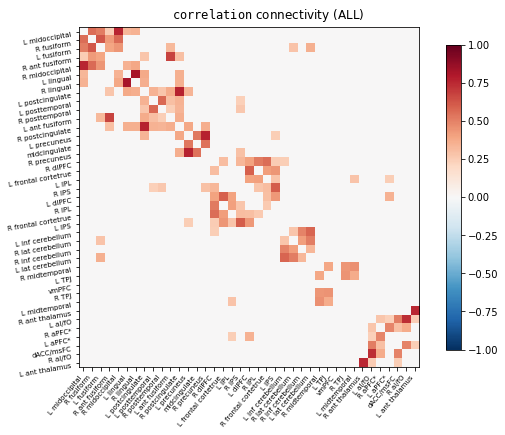

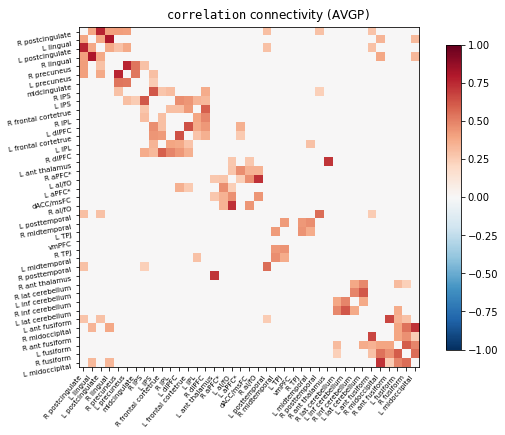

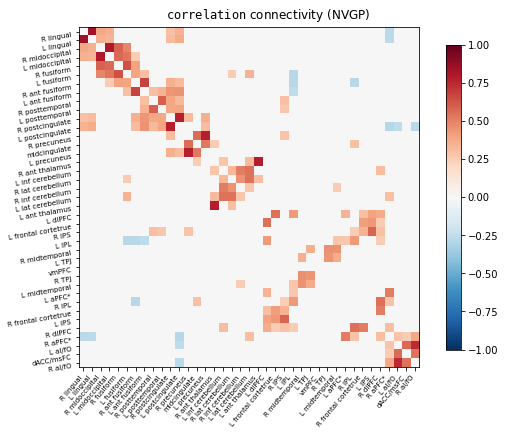

In [255]:
# plot mean connectivity (accross all, NVGP, and AVGP participants)

def plot_connectivity(connectivity_matrix, subject, labels=ds.coords['region'].values):
  
  conn = connectivity_matrix.copy()
  
  # cohen2014 - chapter 41 (p 433)
  threshold = conn.std() + np.median(conn)
  conn_bin = np.where(np.abs(conn) > threshold, conn, 0)  # mask.astype(np.float32)

  # improve visualization by removing diagonals
  np.fill_diagonal(conn_bin, 0)

  # cluster and visualize using nilearn
  fig, _ = plt.subplots(figsize=(7,7))
  plotting.plot_matrix(conn_bin, labels=labels,
                       figure=fig,
                       vmin=-1.0,
                       vmax=1.0,
                       reorder='average',
                       colorbar=True)
  plt.suptitle('$\mathtt{correlation}$ connectivity 'f'({subject})',
               y=.88)
  plt.show()

plot_connectivity(all_cm.mean_, 'ALL')
plot_connectivity(avgp_cm.mean_, 'AVGP')
plot_connectivity(nvgp_cm.mean_, 'NVGP')

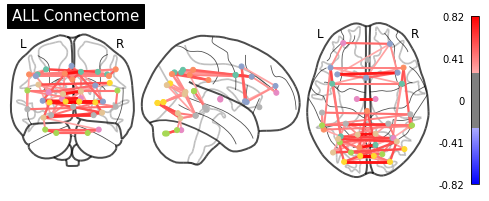

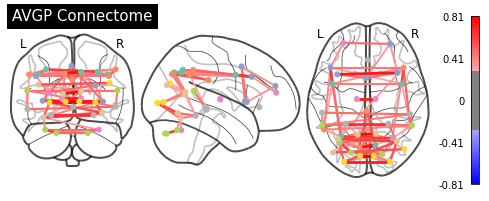

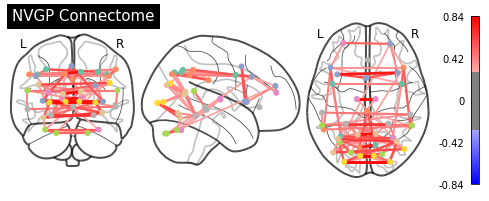

In [212]:
# plot the average connectivity on the brain (edges are thresholded)

plotting.plot_connectome(all_cm.mean_,
                         ds['regions'].values,
                         edge_threshold='90%',
                         node_size=25,
                         title='ALL Connectome',
                         colorbar=True)
plt.show()

plotting.plot_connectome(avgp_cm.mean_,
                         ds['regions'].values,
                         edge_threshold='90%',
                         node_size=25,
                         title='AVGP Connectome',
                         colorbar=True)
plt.show()

plotting.plot_connectome(nvgp_cm.mean_,
                         ds['regions'].values,
                         edge_threshold='90%',
                         node_size=25,
                         title='NVGP Connectome',
                         colorbar=True)
plt.show()

@dosenbach2007 applied a fixed threshold to the connectivity matrix and plotted the remaining edges.

Although they used the 0.2 as a threshold to binerize the correlation matrix, here we use 0.32 to keeps the same number of edges in the graph as in @dosenbach2007. With this threshold, 61 edges remain.

The output figure reflects two aspects of the connectome:

1. spring implies that distances between nodes show how much they are correlated
2. node colors show the network introduced in the @dosenbach2007 paper.

61 edges remained after thresholding.


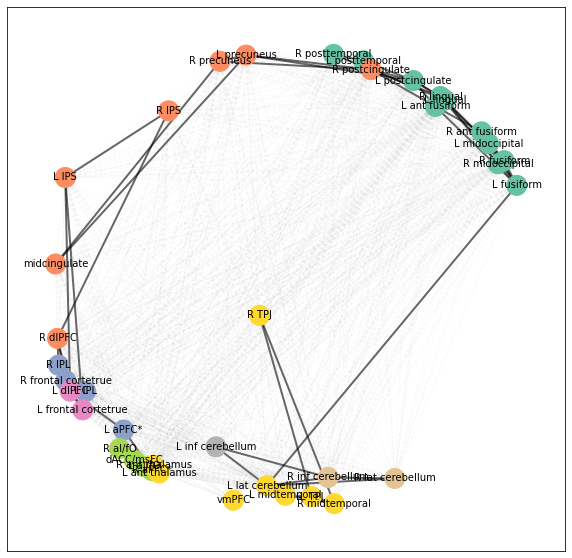

In [132]:
# FIXME dosenbach colors are not avilable in the xarray ds

threshold = 0.32  # 61 edges remain with this value (as in Dosenbach2007)

plt.figure(1,figsize=(10,10)) 

# colors
rgb_values = sns.color_palette("Set2", ROI_DATA['Comp'].nunique())
colors = [rgb_values[c-1] for c in ROI_DATA['Comp'].to_list()]  # Map label to RGB

G = nx.from_numpy_matrix(mean_conn_df.values)
G_labels = {n:lab for n,lab in enumerate(labels)}

e_large = [(u, v) for (u, v, d) in G.edges(data=True) if abs(d["weight"]) > threshold]
e_small = [(u, v) for (u, v, d) in G.edges(data=True) if abs(d["weight"]) <= threshold]

print('{} edges remained after thresholding.'.format(len(e_large)))

# layout
initial_pos=None
initial_pos = nx.circular_layout(G)
pos = nx.spring_layout(G, k=.3, weight='weight', pos=initial_pos)

# draw nodes
nx.draw_networkx_nodes(G, pos, node_size=400, node_color=colors)

# draw edges
nx.draw_networkx_edges(G, pos, edgelist=e_large, alpha=0.6, width=2)
nx.draw_networkx_edges(
    G, pos, edgelist=e_small, width=1, alpha=0.05, edge_color='gray', style="dashed"
)

# labels
nx.draw_networkx_labels(G, pos, labels=G_labels, font_size=10)

# plt.axis('off')
plt.show()


# Method 2: same-colored nodes
# plt.figure(1,figsize=(10,10)) 

# df = pd.DataFrame(np.tril(mean_conn)).stack().reset_index()
# df.columns = ['source', 'target', 'weight']
# df = df.query('weight >= @threshold')
# G = nx.from_pandas_edgelist(df)
# nx.draw(G,
#         pos=pos,
#         with_labels=True,
#         labels=nx_labels,
#         node_color='orange', edge_color='gray',
#         node_size=400, font_size=10)

# plt.show()

# Method 3: GraphViz
# from IPython.display import Image
# import graphviz

# A = nx.drawing.nx_pydot.to_pydot(G)
# graphviz.Source(A)